# YOLOv8 Tutorial – Human Detection for Search and Rescue (SAR)

This notebook walks through a **complete, practical example** of using **transfer learning** with **YOLOv8** to detect **humans in search and rescue (SAR) images**. The focus is not only on getting a model to work, but also on understanding how to make it **cost-efficient**: faster training, lighter models, and reasonable accuracy for time-critical disaster response.

We will start from a **pretrained YOLOv8 model** (trained on a large generic dataset like COCO) and **fine-tune** it on a smaller SAR dataset (e.g., SARD – Search And Rescue Dataset). This is the core idea of transfer learning: instead of training from scratch, we reuse existing knowledge and only “adapt” the model to our new task (detecting tiny people in aerial images).

Throughout the notebook, we will:

- Set up the environment in Google Colab (GPU, libraries).
- Prepare a SAR dataset in **YOLO format** (images + label files).
- Create a small `data.yaml` file to tell YOLO where the data is and what classes we have.
- Visualize some training images and labels to understand the data.
- Fine-tune **YOLOv8n (nano)** as a **lightweight, cost-efficient model**.
- Evaluate the model’s accuracy and speed.
- Run inference on sample images to see how well it detects people.

## Cell 1 — Mount Google Drive (optional but recommended)

We mount Google Drive so that **datasets, patches, and model checkpoints** are saved in your Drive and **persist after the Colab session ends**.  
- You’ll be asked to **authorize** access; a `drive` folder will appear at `/content/drive`.  
- If you prefer **faster I/O** (slightly quicker training) and don’t need persistence, you can skip this and write to `/content/…` instead.

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Cell 1 – Install the Ultralytics (YOLOv8) library

In this cell, we install the **Ultralytics** package, which provides the official implementation of **YOLOv8**.

- `pip` is Python’s package manager; we use it to install external libraries.
- `ultralytics` includes everything we need to train, validate, and run YOLOv8 models.
- The `-q` flag (“quiet”) just reduces the amount of text printed in the output.

After running this cell, we will be able to import and use YOLOv8 in the rest of the notebook.

---

In [ ]:
!pip install -q ultralytics


### Cell 2 – Check PyTorch installation and GPU availability

This cell verifies that **PyTorch** is available and checks whether we can use a **GPU**.

- `import torch` loads the PyTorch library.
- `torch.__version__` prints the installed PyTorch version.
- `torch.cuda.is_available()` returns:
  - `True` if CUDA (GPU support) is available.
  - `False` if we only have a CPU.

Having CUDA available means training will run on the GPU, which is much faster than training on the CPU. This is important for keeping training time and cost reasonable.

---

In [ ]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.8.0+cu126
CUDA available: True


### Cell 3 – Import helper libraries and point to the dataset

This cell imports the libraries we will use for training and visualization, and it sets the path to the SAR dataset.

- `from ultralytics import YOLO` imports the main YOLOv8 interface.
- `Path` (from `pathlib`) helps us work with file system paths in a clean way.
- `matplotlib.pyplot` (`plt`) will be used to display images and plots inside the notebook.
- `cv2` (OpenCV) is used to read images and draw bounding boxes.
- `random` and `os` are standard Python libraries for randomness and file operations.

`%matplotlib inline` is a Jupyter/Colab magic command that tells the notebook to show plots directly under each cell.

`DATA_ROOT` is set to the folder where the **YOLO-formatted SARD dataset** is stored (here, on Google Drive). The print statements help us:

- Check if the dataset folder actually exists (`DATA_ROOT.exists()`).
- List the contents under `DATA_ROOT` so we can confirm we have expected folders such as `train`, `valid`, etc.

---

In [ ]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import random
import os

# Make plots show nicely in notebooks
%matplotlib inline

# Path where you will put the YOLO-formatted SAR dataset
DATA_ROOT = Path("/content/drive/MyDrive/SARD_Original")  # change if needed

print("Dataset root exists:", DATA_ROOT.exists())
print("Structure under DATA_ROOT:")
for p in DATA_ROOT.glob("*"):
    print("  ", p)


Dataset root exists: True
Structure under DATA_ROOT:
   /content/drive/MyDrive/SARD_Original/valid
   /content/drive/MyDrive/SARD_Original/train
   /content/drive/MyDrive/SARD_Original/sard_person.yaml


### Cell 4 – Create the YOLO data configuration file (`sard_person.yaml`)

This cell creates a small **YAML configuration file** that tells YOLO where the data is and which classes we want to detect.

- `path: {DATA_ROOT}` points to the root folder of the dataset.
- `train: train/images` and `val: valid/images` tell YOLO where the training and validation images are located (relative to `path`).
- `names` defines our class list. Here we only have one class, `person`, with ID `0`.

The code builds this YAML text as a Python string (`data_yaml`) and writes it to a file called `sard_person.yaml` inside `DATA_ROOT`.

At the end, it prints the path and contents of the YAML file so we can verify that it looks correct. YOLO will use this file when we start training.

---

In [ ]:
data_yaml = f"""
# SAR person detection (SARD)
path: {DATA_ROOT}   # root of dataset
train: train/images
val: valid/images
#test: test/images   # optional; comment out if you don't have it

names:
  0: person
"""

yaml_path = DATA_ROOT / "sard_person.yaml"
with open(yaml_path, "w") as f:
    f.write(data_yaml)

print("Wrote", yaml_path)
print("----")
print(yaml_path.read_text())


Wrote /content/drive/MyDrive/SARD_Original/sard_person.yaml
----

# SAR person detection (SARD)
path: /content/drive/MyDrive/SARD_Original   # root of dataset
train: train/images
val: valid/images
#test: test/images   # optional; comment out if you don't have it

names:
  0: person



### Cell 5 – Visualize sample training images and labels

This cell defines helper functions to read YOLO labels and draw bounding boxes, then visualizes a few random training images.

1. **`load_yolo_labels` function**
   - Reads a YOLO label file (`.txt`) line by line.
   - Each line has 5 values: `class_id x_center y_center width height`, all normalized between 0 and 1.
   - The function returns a list of bounding boxes, each as `(cls_id, x_c, y_c, w, h)`.

2. **`draw_yolo_boxes` function**
   - Takes an image (`img_bgr`) and the list of boxes.
   - Converts the normalized coordinates into actual pixel coordinates using the image width and height.
   - Draws rectangles (`cv2.rectangle`) for each bounding box on the image.

3. **Main visualization loop**
   - Looks in `train/images` for `.jpg` and `.png` files and collects the image paths.
   - Prints how many training images were found.
   - Randomly selects up to 3 images.
   - For each image:
     - Computes the matching label file path (`train/labels/<same_name>.txt`).
     - Reads the image with OpenCV.
     - Loads the bounding boxes using `load_yolo_labels`.
     - Draws the boxes on the image using `draw_yolo_boxes`.
     - Converts from BGR (OpenCV default) to RGB for correct colors in `matplotlib`.
     - Displays the image with boxes and shows how many boxes are present.

This step is very important for sanity-checking the dataset: we visually confirm that labels are aligned with the correct humans in the image before training.

---

Found 100 train images

Image: gss1944_jpg.rf.80bd231cf1aa5a3b48582e91421a3de2.jpg
Label file exists: True


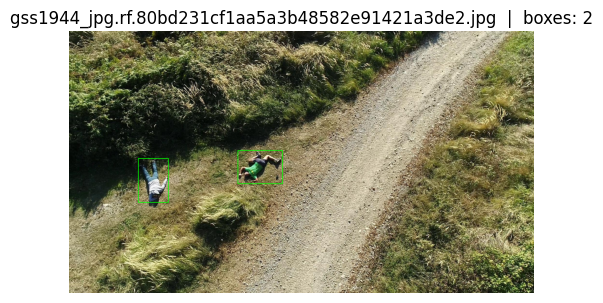


Image: gss1992_jpg.rf.98b78bb76c12ecd3af6e2dbdf6e714ca.jpg
Label file exists: True


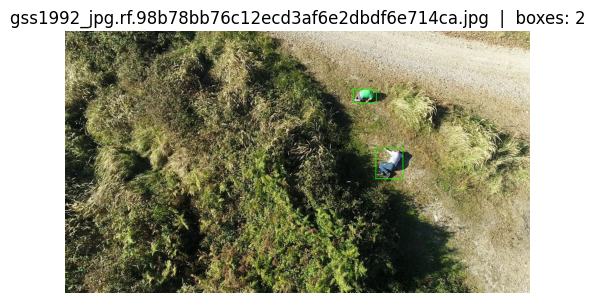


Image: gss2055_jpg.rf.b31a5e750ef83cd4bcc7674c26d5f4cb.jpg
Label file exists: True


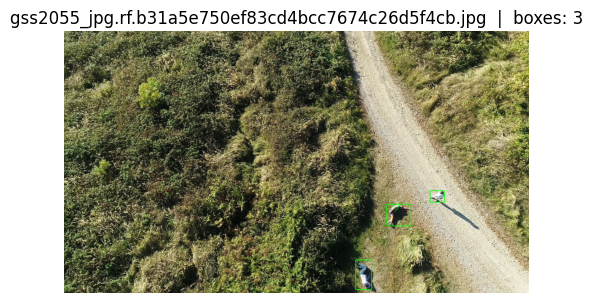

In [ ]:
def load_yolo_labels(label_path):
    """Load YOLO txt file → list of (cls, x_c, y_c, w, h) floats."""
    boxes = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls_id = int(parts[0])
            x_c, y_c, w, h = map(float, parts[1:])
            boxes.append((cls_id, x_c, y_c, w, h))
    return boxes

def draw_yolo_boxes(img_bgr, boxes, color=(0, 255, 0), thickness=2):
    """Draw YOLO-format boxes on an OpenCV image (BGR)."""
    h, w = img_bgr.shape[:2]
    for cls_id, x_c, y_c, bw, bh in boxes:
        x1 = int((x_c - bw/2) * w)
        y1 = int((y_c - bh/2) * h)
        x2 = int((x_c + bw/2) * w)
        y2 = int((y_c + bh/2) * h)
        cv2.rectangle(img_bgr, (x1, y1), (x2, y2), color, thickness)
    return img_bgr

# Pick a few random training images
train_images_dir = DATA_ROOT / "train" / "images"
image_paths = list(train_images_dir.glob("*.jpg")) + list(train_images_dir.glob("*.png"))

print("Found", len(image_paths), "train images")

for img_path in random.sample(image_paths, min(3, len(image_paths))):
    label_path = DATA_ROOT / "train" / "labels" / (img_path.stem + ".txt")
    print("\nImage:", img_path.name)
    print("Label file exists:", label_path.exists())

    img = cv2.imread(str(img_path))
    boxes = load_yolo_labels(label_path)
    img = draw_yolo_boxes(img, boxes)

    # Convert BGR → RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 4))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"{img_path.name}  |  boxes: {len(boxes)}")
    plt.show()


### Cell 6 – Load a pretrained YOLOv8 nano model

This cell loads a **pretrained YOLOv8n (nano)** model, which we will fine-tune on our SAR dataset.

- `YOLO("yolov8n.pt")` loads the nano version of YOLOv8, already trained on the **COCO** dataset.
- This is the core of **transfer learning**: instead of starting from random weights, we start from a model that has already learned general visual features (edges, shapes, people, etc.) from a large dataset.
- The returned `model` object will be used later to:
  - Train on our SAR data (`model.train(...)`).
  - Validate and evaluate the model.
  - Run inference on new images.

Using the **nano** model keeps the network lightweight and fast, which fits the theme of **cost-efficient** deep learning for time-critical search and rescue applications.

In [ ]:
from ultralytics import YOLO

# Load a pretrained YOLOv8 nano model (object detection, COCO)
model = YOLO("yolov8n.pt")
model


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

### Cell 7 – Train YOLOv8n (nano) on the SAR dataset

In this cell, we **train (fine-tune)** the pretrained YOLOv8n model on our SAR dataset. This is where the model actually learns to detect people in search-and-rescue images.

- `data=str(DATA_ROOT / "sard_person.yaml")` tells YOLO where the training and validation images are, and that we only have one class: `person`.
- `imgsz=640` sets the input image size. Larger images can help detect **small people** in aerial views, but they also require more memory and take longer to process.
- `epochs=30` is how many times we go through the full training dataset. More epochs usually improve accuracy but also increase training time and cost.
- `batch=16` is how many images are processed in one step. If you get “out of memory” errors on the GPU, you can lower this number.
- `patience=10` turns on **early stopping**: if the model stops improving on the validation set for several epochs, training stops early to save time.
- `lr0=0.001` is the initial learning rate. It controls how big each update step is when the model adjusts its weights.
- `optimizer="SGD"` chooses the optimization algorithm. You can try `"Adam"` or `"AdamW"` and compare training behaviour and results.
- `device=0` tells YOLO to use the first GPU. If you change it to `"cpu"`, training will run on the CPU (much slower).
- `project` and `name` decide where YOLO will save logs, plots, and model weights.
- `pretrained=True` is the key for **transfer learning**: we start from a YOLOv8n model already trained on COCO and adapt it to the SAR task, instead of training from scratch. This saves data, time, and compute.

---

In [ ]:
results = model.train(
    data=str(DATA_ROOT / "sard_person.yaml"),  # our data config
    imgsz=640,          # image size; higher → better small-object detection but more compute
    epochs=30,          # increase later if you want better accuracy
    batch=16,           # tune based on GPU memory (lower if OOM)
    patience=10,        # early stopping if val metrics stop improving
    lr0=0.001,          # starting learning rate
    optimizer="SGD",    # you can also try "Adam" or "AdamW"
    device=0,           # 0 = first GPU; "cpu" for CPU-only
    project="sar_yolov8_tutorial",
    name="yolov8n_sard",
    pretrained=True,    # important: reuse COCO weights → transfer learning
    verbose=True
)


Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/SARD_Original/sard_person.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_sard8, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=10, perspe

### Cell 8 – Validate YOLOv8n: measure accuracy and speed

In this cell, we load the **best saved checkpoint** from training and evaluate it on the validation data.

- `best_model = YOLO(".../best.pt")` loads the model file that YOLO saved when validation performance was highest.
- `best_model.val(...)` runs evaluation on the validation images using the same `sard_person.yaml` configuration.
- `mAP50` is the mean Average Precision at IoU 0.5. It is a common accuracy metric for object detection; higher is better.
- `mAP50-95` is a stricter metric that averages mAP over several IoU thresholds (from 0.5 to 0.95). It gives a more complete view of performance.
- `metrics.speed.get('inference', None)` reports the **inference time per image** in milliseconds, which tells us how fast the model can process images.

This cell gives us both **how well** the model detects people and **how quickly** it can run, which is important for real-time disaster response.

---

In [ ]:
# Load the best weights from the training run
best_model = YOLO("/content/sar_yolov8_tutorial/yolov8n_sard8/weights/best.pt")

metrics = best_model.val(
    data=str(DATA_ROOT / "sard_person.yaml"),
    imgsz=640
)

print("mAP50:", metrics.box.map50)      # mAP at IoU 0.5
print("mAP50-95:", metrics.box.map)     # COCO-style mAP
print("Speed (ms per image):", metrics.speed.get('inference', None))


Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 237.1±40.1 MB/s, size: 743.3 KB)
val: Scanning /content/drive/MyDrive/SARD_Original/valid/labels.cache... 792 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 792/792 1.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 2.2it/s 22.3s
                   all        792       2605      0.495      0.368      0.291      0.115
Speed: 1.5ms preprocess, 3.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /content/runs/detect/val
mAP50: 0.2907281892135396
mAP50-95: 0.1149876632909758
Speed (ms per image): 3.2823235669196844


### Cell 9 – Run inference on validation images and visualize predictions

In this cell, we test the trained model on some **validation images** and display the predicted bounding boxes.

- We collect all images under `valid/images` and count how many we have.
- `random.sample(...)` picks up to 5 images at random so we can inspect a few different scenes.
- `best_model.predict(...)` runs the model on these images:
  - `imgsz=640` keeps the same input size as training.
  - `conf=0.25` sets the minimum confidence score for a detection to be kept.
- For each image:
  - `res.plot()` returns a copy of the image with the predicted boxes drawn on it.
  - We convert the colors from BGR to RGB (so they look correct) and display the image with `matplotlib`.

This visual check is very helpful: you and your audience can **see** how the model performs on real SAR images—where it finds people, and where it may miss or mis-detect them.

---

Val images: 792

Image: gss1618_jpg.rf.1cbf08f50b34aaf2c6624a259a840cf3.jpg


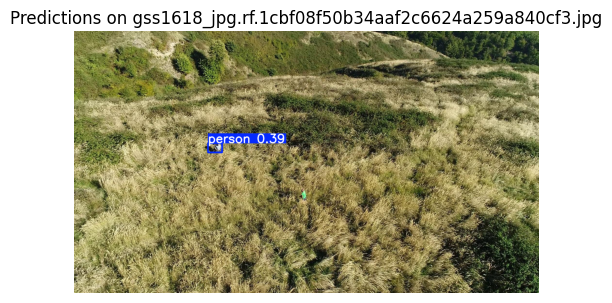


Image: gss1262_jpg.rf.e48c12efd01e685a13f5a3b910941d17.jpg


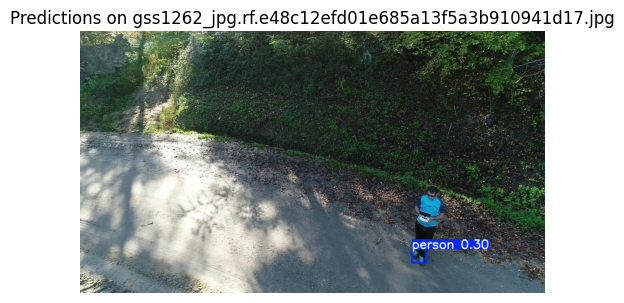


Image: gss893_jpg.rf.5c026513c306e0fb8611039effe53dda.jpg


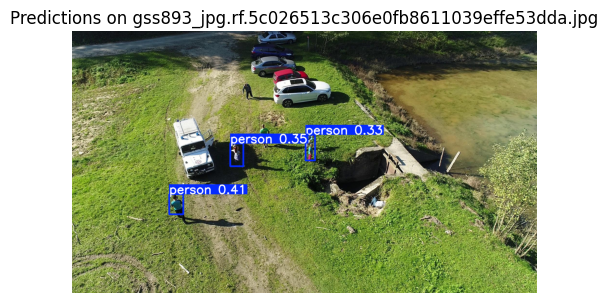


Image: gss1442_jpg.rf.15af9f62cf3bb1e5d16d793ea2b1c41b.jpg


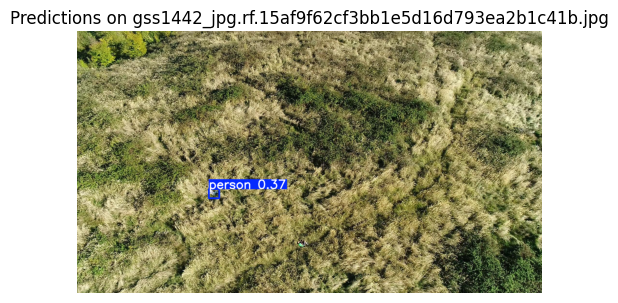


Image: gss476_jpg.rf.b4dc729797f2e77f9d25c851e034d40c.jpg


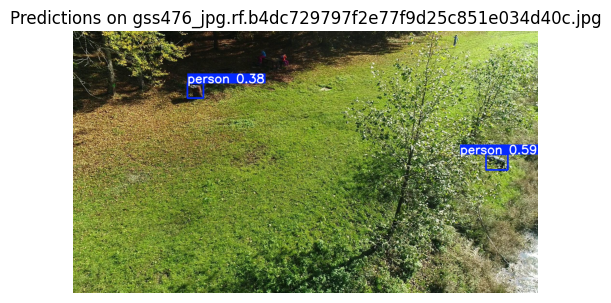

In [ ]:
# Pick some random validation images
val_images_dir = DATA_ROOT / "valid" / "images"
val_images = list(val_images_dir.glob("*.jpg")) + list(val_images_dir.glob("*.png"))
print("Val images:", len(val_images))

sample_imgs = random.sample(val_images, min(5, len(val_images)))

results = best_model.predict(
    source=[str(p) for p in sample_imgs],
    imgsz=640,
    conf=0.25,
    verbose=False
)

for img_path, res in zip(sample_imgs, results):
    print("\nImage:", img_path.name)
    # res.plot() returns an image (numpy array) with drawn boxes
    plotted = res.plot()
    plt.figure(figsize=(6, 4))
    plt.imshow(cv2.cvtColor(plotted, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Predictions on {img_path.name}")
    plt.show()


### Cell 10 – OPTIONAL: Train YOLOv8s (small) for comparison

This cell is optional and is used to explore the **trade-off between model size, accuracy, and speed**.

- `model_s = YOLO("yolov8s.pt")` loads the **small** version of YOLOv8, which is larger and usually more accurate than YOLOv8n, but also heavier and slower.
- We call `model_s.train(...)` with similar settings:
  - Same data file (`sard_person.yaml`).
  - Same image size, epochs, batch size, and patience.
  - `pretrained=True` again uses COCO weights for transfer learning.
- Training YOLOv8s on the same task lets us later compare:
  - Does the small model get better accuracy?
  - How much extra training and inference cost do we pay?

This is a good cell to support a discussion about **cost-efficient model choices** in disaster response.

---

In [ ]:
# OPTIONAL: train YOLOv8s (small) for comparison
model_s = YOLO("yolov8s.pt")

results_s = model_s.train(
    data=str(DATA_ROOT / "sard_person.yaml"),
    imgsz=640,
    epochs=30,
    batch=16,
    patience=10,
    device=0,
    project="sar_yolov8_tutorial",
    name="yolov8s_sard",
    pretrained=True
)




Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/SARD_Original/sard_person.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_sard, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspec

FileNotFoundError: [Errno 2] No such file or directory: 'runs/detect/yolov8s_sard/weights/best.pt'

### Cell 11 – Compare YOLOv8n and YOLOv8s: accuracy and speed

In this cell, we evaluate the **small model (YOLOv8s)** and directly compare it to the **nano model (YOLOv8n)**.

- `best_model_s = YOLO("runs/detect/yolov8s_sard/weights/best.pt")` loads the best checkpoint of the small model.
- `best_model_s.val(...)` evaluates the small model on the same SAR validation set.
- We print:
  - `YOLOv8n mAP50` (from the nano model’s metrics) and `YOLOv8s mAP50` to compare detection accuracy.
  - `YOLOv8n speed (ms/img)` and `YOLOv8s speed (ms/img)` to compare processing speed per image.

This side-by-side comparison clearly shows the **trade-off**:

- YOLOv8s may achieve **higher accuracy**.
- YOLOv8n is usually **faster and lighter**, which can be critical when hardware is limited or when we need rapid results for search-and-rescue decisions.

In [ ]:
# Validate small model
best_model_s = YOLO("/content/sar_yolov8_tutorial/yolov8s_sard/weights/best.pt")
metrics_s = best_model_s.val(data=str(DATA_ROOT / "sard_person.yaml"), imgsz=640)

print("YOLOv8n mAP50:", metrics.box.map50)
print("YOLOv8s mAP50:", metrics_s.box.map50)
print("YOLOv8n speed (ms/img):", metrics.speed.get('inference', None))
print("YOLOv8s speed (ms/img):", metrics_s.speed.get('inference', None))

Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 229.6±34.6 MB/s, size: 743.3 KB)
val: Scanning /content/drive/MyDrive/SARD_Original/valid/labels.cache... 792 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 792/792 773.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 2.2it/s 23.1s
                   all        792       2605      0.606      0.448      0.453      0.199
Speed: 1.3ms preprocess, 5.3ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to /content/runs/detect/val2
YOLOv8n mAP50: 0.2907281892135396
YOLOv8s mAP50: 0.4528281799379528
YOLOv8n speed (ms/img): 3.2823235669196844
YOLOv8s speed (ms/img): 5.275475393937591
